In [149]:
pip install lightkurve 

Note: you may need to restart the kernel to use updated packages.


In [150]:
# Import the necessary library
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [151]:
# Define the TIC ID and sector number
tic_id = '   207468071         '  # Example TIC ID
sector_id = 23 # Example sector ID

# Search and download the light curve data for the specified TIC ID and sector
search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS', sector=sector_id, exptime=120, author='SPOC')
lc = search_result.download()
lc = lc.normalize()
lc= lc.remove_outliers(sigma=6) # clip the light curve to remove deviant datapoints greater than 6 sigma

# Check if the light curve data is loaded successfully
if lc is not None:
    print("Light curve data loaded successfully.")
else:
    print(f"No light curve data available for TIC {tic_id} in sector {sector_id}.")


Light curve data loaded successfully.


In [152]:
#Lightkurves / Flatten / Phase Fold / Zoom in 

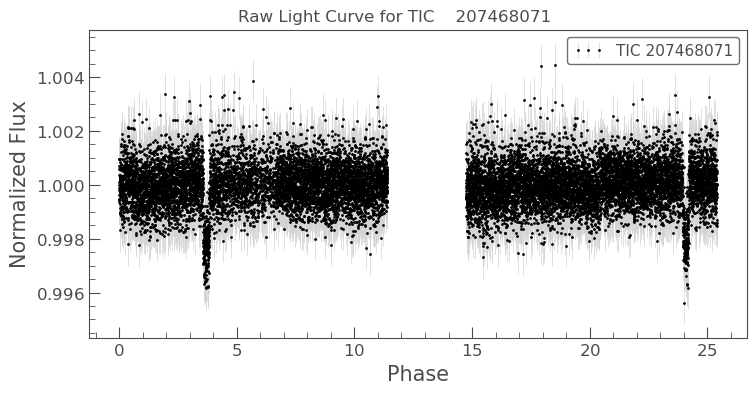

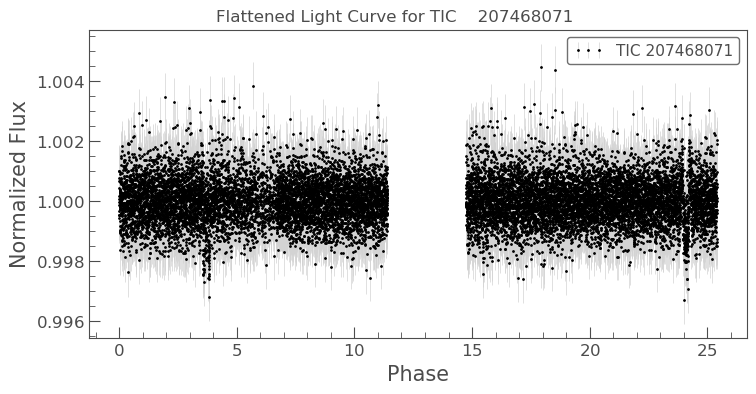

In [153]:
# Check if the light curve data exists
if lc is not None:
    # Adjust the time values to start from zero
    lc['time'] = lc['time'].mjd - lc[0]['time'].mjd

    # Plot the adjusted light curve
    lc.errorbar(fmt='.', ecolor='LightGrey', color='black')
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')
    plt.title(f'Raw Light Curve for TIC {tic_id}')
    plt.show()
    
    # Flatten the light curve to remove long-term trends
    flat_lc = lc.flatten(window_length=401)
    flat_lc.errorbar(fmt='.', ecolor='LightGray', color='black') 
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')
    plt.title(f'Flattened Light Curve for TIC {tic_id}')
    plt.show()
else:
    print(f"No light curve data available for TIC {tic_id}")

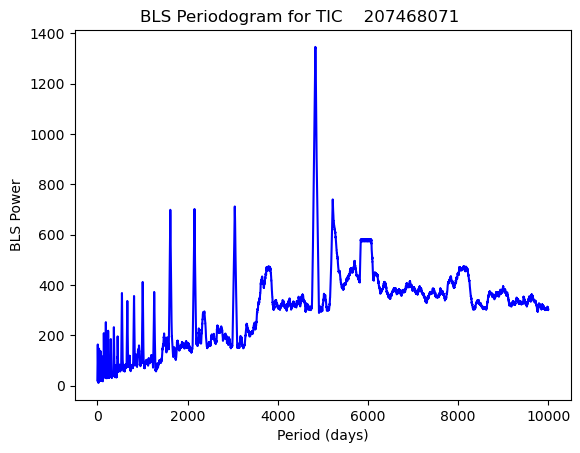

In [154]:
period = np.linspace(1, 20, 10000)  # searching for periods from 1 to 20 days
bls = lc.to_periodogram('bls', period=period, frequency_factor=1000)

# Plotting the BLS periodogram
plt.plot(bls.power, color='blue')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title(f'BLS Periodogram for TIC {tic_id}')
plt.show()


In [155]:
from astroquery.mast import Catalogs

# Trim any whitespace from the TIC ID for a successful query
tic_id_cleaned = tic_id.strip()

# Query the TIC catalog for the specific star using its TIC ID
catalogData = Catalogs.query_criteria(catalog="TIC", ID=tic_id_cleaned)

# Display the catalog data
print(catalogData)

# Extract the star's radius and its error from the catalog data
radius = catalogData['rad'].pformat(show_name=False)[0]
radius_error = catalogData['e_rad'].pformat(show_name=False)[0]

# Print the star's estimated radius
print("Star's estimated radius: " + radius + ' +/- ' + radius_error + ' Solar radii')


    ID    version  HIP     TYC      ... raddflag wdflag   objID  
--------- -------- --- ------------ ... -------- ------ ---------
207468071 20190415  -- 3878-01463-1 ...        1      0 160387584
Star's estimated radius: 1.61988 +/- 0.0676734 Solar radii


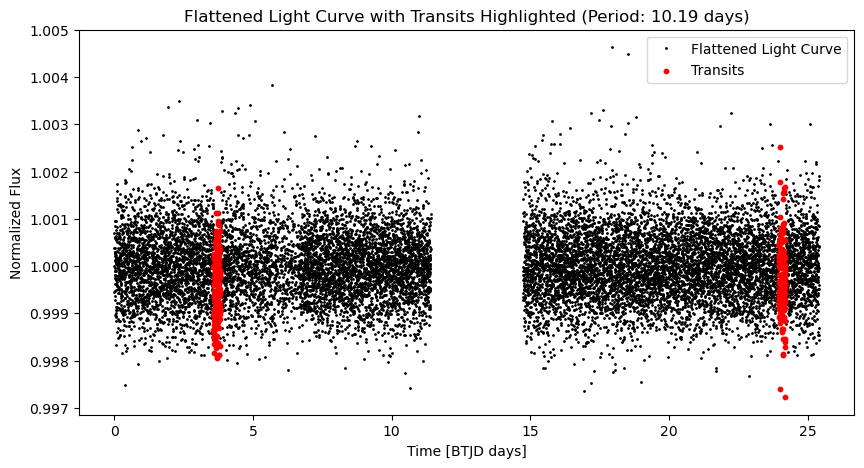

<Figure size 1000x500 with 0 Axes>

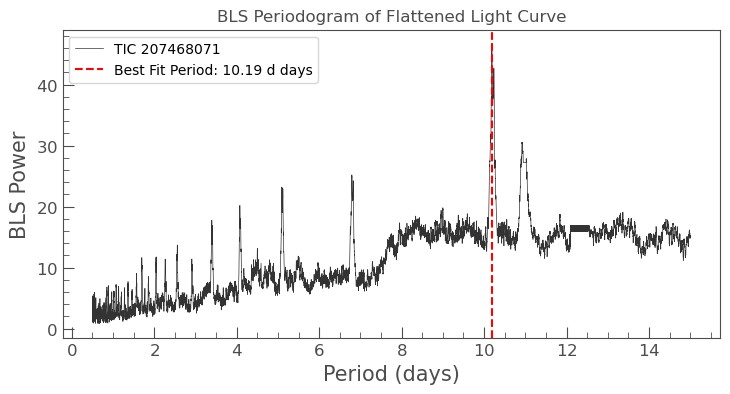

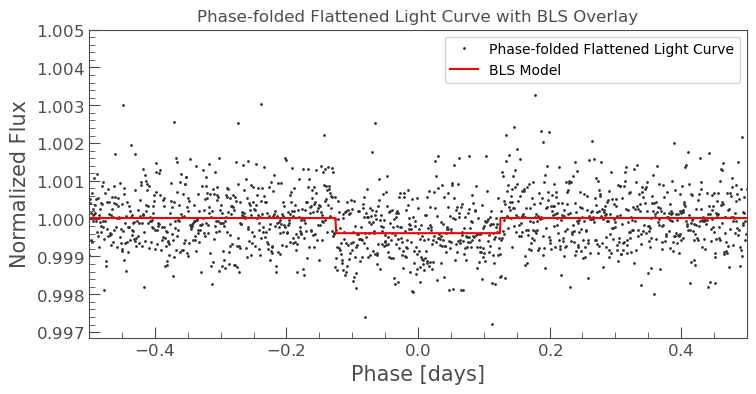

In [156]:
import matplotlib.pyplot as plt

# Flatten the light curve to remove long-term trends
flat_lc, trend_lc = lc.flatten(return_trend=True)

# Perform BLS Analysis on the flattened light curve to find the best fit period and epoch
bls_results = flat_lc.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
best_fit_period = bls_results.period_at_max_power
best_fit_t0 = bls_results.transit_time_at_max_power

# Highlight the transits on the flattened light curve
transit_mask = bls_results.get_transit_mask(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
plt.figure(figsize=(10, 5))
plt.plot(flat_lc.time.value, flat_lc.flux, 'k.', label='Flattened Light Curve', linestyle='none', markersize=2)
plt.scatter(flat_lc.time.value[transit_mask], flat_lc.flux[transit_mask], color='red', label='Transits', zorder=2, s=10)
plt.legend()
plt.xlabel('Time [BTJD days]')
plt.ylabel('Normalized Flux')
plt.title(f'Flattened Light Curve with Transits Highlighted (Period: {best_fit_period.value:.2f} days)')
plt.savefig('transits_highlighted.png')  # Save the figure to a file
plt.show()

# Plot the BLS periodogram of the flattened light curve
plt.figure(figsize=(10, 5))
bls_results.plot()
plt.axvline(x=best_fit_period.value, color='r', linestyle='--', label=f'Best Fit Period: {best_fit_period:.2f} days')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title('BLS Periodogram of Flattened Light Curve')
plt.legend()
plt.savefig('bls_periodogram.png')  # Save the figure to a file
plt.show()

# Plot the folded light curve with BLS model overlaid on the flattened data
folded_lc = flat_lc.fold(period=best_fit_period.value, epoch_time=best_fit_t0.value)
bls_model = bls_results.get_transit_model(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
folded_lc.plot(label='Phase-folded Flattened Light Curve', marker='.', linestyle='none')
plt.plot(folded_lc.time.value, bls_model.fold(period=best_fit_period, epoch_time=best_fit_t0).flux, color='red', label='BLS Model')
plt.legend()
plt.xlabel('Phase [days]')
plt.ylabel('Normalized Flux')
plt.title('Phase-folded Flattened Light Curve with BLS Overlay')
plt.savefig('phase_folded_bls_overlay.png')  # Save the figure to a file
plt.xlim(-0.5,0.5)
plt.show()


In [157]:
from astroquery.mast import Catalogs

# Clean up the TIC ID and query the TIC catalog
tic_id_cleaned = tic_id.strip()
catalogData = Catalogs.query_criteria(catalog="TIC", ID=tic_id_cleaned)

# Extract and print the star's parameters
print(f"Star's Name: {catalogData['ID'][0]}")
print(f"Radius (Rs): {catalogData['rad'][0]:.2f} ± {catalogData['e_rad'][0]:.2f} Solar radii")
print(f"Mass (Ms): {catalogData['mass'][0]:.2f} ± {catalogData['e_mass'][0]:.2f} Solar masses")
print(f"Metallicity [Fe/H]: {catalogData['MH'][0]:.2f} ± {catalogData['e_MH'][0]:.2f}")
print(f"Surface Gravity log(g): {catalogData['logg'][0]:.2f} ± {catalogData['e_logg'][0]:.2f}")
print(f"Effective Temperature (Teff): {catalogData['Teff'][0]:.0f} ± {catalogData['e_Teff'][0]:.0f} K")
print(f"V-band Magnitude: {catalogData['Tmag'][0]}")
print(f"K-band Magnitude: {catalogData['Kmag'][0]}")
print(f"Right Ascension (RA): {catalogData['ra'][0]}")
print(f"Declination (Dec): {catalogData['dec'][0]}")
print(f"Distance: {catalogData['d'][0]:.2f} ± {catalogData['e_d'][0]:.2f} parsecs")


Star's Name: 207468071
Radius (Rs): 1.62 ± 0.07 Solar radii
Mass (Ms): 1.26 ± 0.18 Solar masses
Metallicity [Fe/H]: nan ± nan
Surface Gravity log(g): 4.12 ± 0.08
Effective Temperature (Teff): 6351 ± 119 K
V-band Magnitude: 9.29416
K-band Magnitude: 8.531
Right Ascension (RA): 245.908208978109
Declination (Dec): 54.6897621683146
Distance: 191.65 ± 0.92 parsecs


In [158]:
# Find the out-of-transit baseline flux level (assuming it's around the median of the out-of-transit data)
baseline_flux = np.median(folded_lc.flux[~transit_mask])

# Find the flux at the minimum point of the transit (deepest part of the dip)
transit_flux = np.min(folded_lc.flux[transit_mask])

# Calculate the transit depth
transit_depth = (baseline_flux - transit_flux) / baseline_flux

# Express the transit depth in percentage
transit_depth_pct = transit_depth * 100

# Print the transit depth
print(f"Transit depth: {transit_depth_pct:.3f}%")

Transit depth: 0.225%


In [159]:
from astropy.constants import R_sun, R_jup
import numpy as np

# Flatten the light curve and run BLS on the flattened light curve
#flat_lc, trend_lc = lc.flatten(return_trend=True)
#bls_results = flat_lc.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
#best_fit_period = bls_results.period_at_max_power
#best_fit_t0 = bls_results.transit_time_at_max_power
transit_depth = bls.depth_at_max_power  # Depth from the flattened light curve

# Assuming 'catalogData' is the result from the TIC catalog query.
star_radius_sol = catalogData['rad'][0]  # Star radius in solar radii
star_radius_error = catalogData['e_rad'][0]  # Error in star radius

# Convert star radius from solar radii to meters
star_radius_m = star_radius_sol * R_sun.value

# Calculate the planet radius in meters using the transit depth
# (Depth is the (Rp/R_star)^2)
planet_radius_m = np.sqrt(transit_depth) * star_radius_m

# Convert the planet's radius from meters to Jupiter radii
planet_radius_rj = planet_radius_m / R_jup.value

# Calculate the error in the planet's radius
# Assuming the error in transit depth is negligible compared to the star's radius error
planet_radius_error_rj = 0.5 * (transit_depth**-0.5) * (star_radius_error / star_radius_sol) * planet_radius_rj

# Print the planet's radius in Jupiter radii and its error
print(f"Estimated radius of the exoplanet: {planet_radius_rj:.3f} Jupiter radii")
print(f"Error in the exoplanet's radius: ±{planet_radius_error_rj:.3f} Jupiter radii")


Estimated radius of the exoplanet: 0.730 Jupiter radii
Error in the exoplanet's radius: ±0.329 Jupiter radii


In [160]:
print(transit_depth)

0.0021452545177393493


In [161]:
import numpy as np
import lightkurve as lk

# Define the number of bootstrap iterations
num_bootstrap_iterations = 10  # for example, you might need more

# Flatten the original light curve to remove long-term trends
flat_lc, trend_lc = lc.flatten(return_trend=True)

# Arrays to store the bootstrap results
bootstrap_periods = []
bootstrap_durations_hours = []  # Store durations in hours

# Conduct the bootstrap resampling
for i in range(num_bootstrap_iterations):
    # Randomly select data points with replacement to create a bootstrap sample
    indices = np.random.choice(len(flat_lc.time.value), len(flat_lc.time.value))
    bootstrap_lc = lk.LightCurve(time=flat_lc.time.value[indices], flux=flat_lc.flux.value[indices])

    # Perform BLS analysis on the resampled flattened light curve
    bls_results_bootstrap = bootstrap_lc.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
    
    # Store the period from each bootstrap iteration
    bootstrap_periods.append(bls_results_bootstrap.period_at_max_power.value)
    
    # Store the duration in hours
    bootstrap_durations_hours.append(bls_results_bootstrap.duration_at_max_power.value * 24)  # Convert days to hours

# Calculate the standard deviations of the results as the uncertainties
period_error = np.std(bootstrap_periods)
duration_error_hours = np.std(bootstrap_durations_hours)  # Uncertainty in hours

# Report the results with calculated uncertainties
print(f"Period: {np.mean(bootstrap_periods):.6f} ± {period_error:.6f} days")
print(f"Transit Duration: {np.mean(bootstrap_durations_hours):.6f} ± {duration_error_hours:.6f} hours")


Period: 10.191899 ± 0.012171 days
Transit Duration: 5.760000 ± 0.720000 hours


In [162]:
from astropy.constants import G, M_sun, au
from astropy import units as u

# Assuming these values are obtained from the BLS analysis or earlier steps
P = 20.25 * u.day  # Convert period to astropy Quantity in days
delta_P =  period_error* u.day  # Convert period error to astropy Quantity in days

# Star's mass from the TIC catalog query, converted to astropy Quantity
M_star = catalogData['mass'][0] * u.M_sun
delta_M_star = catalogData['e_mass'][0] * u.M_sun

# Convert period and its error from days to seconds for the calculation
P = P.to(u.second)
delta_P = delta_P.to(u.second)

# Calculate the semi-major axis using Kepler's third law: a^3 = G * M_star * P^2 / (4 * pi^2)
a_cubed = (G * M_star * P**2) / (4 * np.pi**2)
a = a_cubed.cgs**(1/3)

# Convert a from cm to AU for better readability
a = a.to(u.AU)

# Propagate the uncertainties: (delta_a / a)^2 = (2 * delta_P / P)^2 + (delta_M_star / M_star)^2
fractional_delta_a = np.sqrt((2 * delta_P / P)**2 + (delta_M_star / M_star)**2)
delta_a = fractional_delta_a * a

# Let's assume 'a' and 'delta_a' are your final calculated values for the semi-major axis and its error.

# After all your calculations (outside any loop):
print(f"Semi-major axis: {a} AU")
print(f"Uncertainty in semi-major axis: {delta_a} AU")


Semi-major axis: 0.15708067636215342 AU AU
Uncertainty in semi-major axis: 0.022878377629299538 AU AU


In [163]:
from astropy.constants import sigma_sb, au
from astropy import units as u

# Assuming you have the star's temperature (T_star) and radius (R_star) and their uncertainties
T_star = catalogData['Teff'][0] * u.K
T_star_error = catalogData['e_Teff'][0] * u.K
R_star = catalogData['rad'][0] * R_sun
R_star_error = catalogData['e_rad'][0] * R_sun

# Assuming a placeholder value for semi-major axis 'a' in AU and its error 'a_error'
#a = 0.05 * au  # Replace with your actual value for semi-major axis in astronomical units
#a_error = 0.001 * au  # Replace with your actual uncertainty in semi-major axis

# Assuming zero albedo for simplicity and full heat redistribution
albedo = 0

# Calculate the equilibrium temperature
T_eq = T_star * (np.sqrt(R_star / (2 * a)) * (1 - albedo)**0.25).decompose()

# Calculate the uncertainty in equilibrium temperature using error propagation
# The following propagation assumes the errors are small relative to the values
T_eq_error = T_eq * np.sqrt((T_star_error / T_star)**2 +
                            (0.5 * R_star_error / R_star)**2 +
                            (0.5 * delta_a / a)**2)

# Print the equilibrium temperature with its error
print(f"Planetary equilibrium temperature: {T_eq.value:.2f} K ± {T_eq_error.value:.2f} K")

Planetary equilibrium temperature: 983.46 K ± 76.75 K


In [164]:
import numpy as np
import lightkurve as lk

# Assuming 'lc' is your original LightCurve object
num_iterations = 10  # Number of bootstrap iterations
t0_values = []  # List to store the transit epochs from each iteration

# Flatten the original light curve first
flat_lc, trend_lc = lc.flatten(return_trend=True)

for i in range(num_iterations):
    # Resample the flattened light curve with replacement
    indices = np.random.choice(len(flat_lc.time), len(flat_lc.time))
    resampled_lc = lk.LightCurve(time=flat_lc.time[indices], flux=flat_lc.flux[indices])

    # Perform BLS analysis on the resampled light curve
    bls_periodogram = resampled_lc.to_periodogram(method='bls', period=np.arange(0.5, 20, 0.001), frequency_factor=500)
    resampled_t0 = bls_periodogram.transit_time_at_max_power.value

    # Store the transit epoch
    t0_values.append(resampled_t0)

# Calculate the mean and standard deviation of the transit epochs
mean_t0 = np.mean(t0_values)
std_t0 = np.std(t0_values)

print(f"Estimated transit epoch T0: {mean_t0} ± {std_t0}")


Estimated transit epoch T0: 3.678194453969482 ± 0.025674918538791093


In [165]:
import pandas as pd

# Existing variables and uncertainties
radius_value = planet_radius_rj  # Example planet radius in Jupiter radii
radius_error = planet_radius_error  # Example uncertainty
teq_value = T_eq  # Example equilibrium temperature in Kelvin
teq_error = T_eq_error  # Example uncertainty
period_value = np.mean(bootstrap_periods)  # Example period in days
period_error = period_error  # Example uncertainty
epoch_value = mean_t0  # Example transit epoch in MJD
epoch_error = std_t0  # Example uncertainty
duration_value = np.mean(bootstrap_durations_hours)  # Example transit duration in hours
duration_error = duration_error_hours  # Example uncertainty
depth_value = transit_depth  # Example transit depth in percentage
depth_error = 0  # Example uncertainty

# Add your semi-major axis value and its error
a_value = a  # Replace with your actual semi-major axis value
a_error = delta_a  # Replace with your actual semi-major axis error

# Create a dictionary with the data including the new semi-major axis
data = {
    'Parameter': ['Radius (Rj)', 'Equilibrium Temperature (K)', 'Period (days)', 'Transit Epoch (MJD)', 'Transit Duration (hours)', 'Transit Depth (%)', 'Semi-major Axis (AU)'],
    'Value': [radius_value, teq_value, period_value, epoch_value, duration_value, depth_value, a_value],
    'Uncertainty': [radius_error, teq_error, period_error, epoch_error, duration_error, depth_error, a_error]
}

# Create the DataFrame
planet_parameters_df = pd.DataFrame(data)

# Add the plus-minus symbol to the 'Uncertainty' column
planet_parameters_df['Uncertainty'] = "± " + planet_parameters_df['Uncertainty'].astype(str)

# Set the DataFrame to display without an index and format the columns for neat display
formatted_df = planet_parameters_df.to_string(index=False)
print(formatted_df)

# You can then export this DataFrame to an Excel file
planet_parameters_df.to_excel('planet_parameters.xlsx', index=False)

print("Data has been exported to 'planet_parameters.xlsx'")


                  Parameter                  Value               Uncertainty
                Radius (Rj)     0.7301075049349877      ± 0.2182771064639327
Equilibrium Temperature (K)    983.4571700229662 K     ± 76.74912671005414 K
              Period (days)              10.191899    ± 0.012170855535400696
        Transit Epoch (MJD)               3.678194    ± 0.025674918538791093
   Transit Duration (hours)                   5.76      ± 0.7200000000000001
          Transit Depth (%)  0.0021452545177393493                       ± 0
       Semi-major Axis (AU) 0.15708067636215342 AU ± 0.022878377629299538 AU
Data has been exported to 'planet_parameters.xlsx'
